# VGAE framework

In [1]:
import torch
torch.cuda.device_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.FloatTensor([0., 1., 2.])
X_train.is_cuda

False

In [9]:
out_channels = 10
n_node = 38
num_features = n_node
w1 = 1
w2 = 2

In [2]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.nn.inits import reset 
EPS = 1e-15
MAX_LOGSTD = 1
 
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                    the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        self.w1 = w1
        self.w2 = w2
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).sum()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).sum()
        N1 = len(-torch.log( self.decoder(z, pos_edge_index, sigmoid=True) + EPS))
        N2 = len(-torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + EPS))

        return (self.w1 * pos_loss + self.w2 * neg_loss) / (N1+N2)


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(VGAE, self).__init__(encoder, w1, w2, decoder)
        self.w1 = w1
        self.w2 = w2

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) 

# IPF data

## Data class

In [8]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5, 5)
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]
            A[:5, :5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, non_orphan_list=None, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.non_orphan_list = non_orphan_list
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + "/"+ sample
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj > 0] = 1
            for i in range(self.n_node):
                adj[i, i] = 0
            for i in range(self.n_node):
                for j in range(self.n_node):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            for i in range(self.n_node - 1, -1, -1):
                if i not in self.non_orphan_list:
                    adj = np.delete(adj, (i), axis=0)
                    adj = np.delete(adj, (i), axis=1)
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(len(self.non_orphan_list))
        x_onehot = torch.eye(len(self.non_orphan_list))[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

def recover_full_matrix(adj_mat, non_orphan_list):
    df = pd.DataFrame(adj_mat, index=non_orphan_list)
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,len(non_orphan_list))), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    df = df.T
    df.index = non_orphan_list
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,38)), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    return np.matrix(df)

def compute_cent(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

import matplotlib.pyplot as plt

def plot_mu_graph(mu):
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

def sample_adj_mat(model=model_ipf, filter_option=True, filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    if filter_option==True:   
        adj_mat[adj_mat < filter_value] = 0
        adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

## Load and train ipf data

In [5]:
full_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))
full_ipf_input_adj_list = []
full_ipf_input_cent_list = []
n = len(full_ipf_data.get_adj_m())
for i in range(n):
    adj_mat = full_ipf_data.get_adj_m()[i]
    full_ipf_input_adj_list.append(adj_mat)
    full_ipf_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ipf_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]
non_orphan_list = range(38)
ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=non_orphan_list)
dataset = ipf_data.graph_dataset()

n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

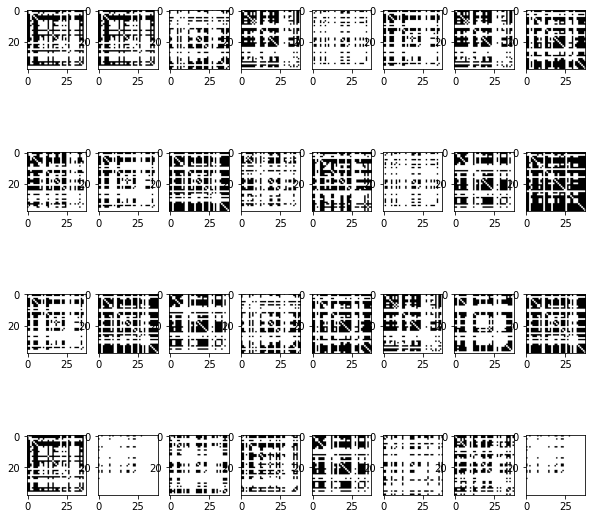

In [6]:
# non-orphan nodes
ipf_index = np.random.choice(range(len(dataset)), size=32)

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ipf_input_adj_list = input_adj_list
ipf_input_cent_list = input_cent_list

# original adj matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
k = 0
for i in ipf_index:
    k += 1
    plt.subplot(4, 8, k)
    plt.imshow(ipf_data.get_adj_m()[i], cmap="Greys")

In [ ]:
for bs_time in range(12, 50):
    
    ipf_index = np.random.choice(range(len(dataset)), size=32)
    input_adj_list = []
    input_cent_list = []

    for i in range(n):
        adj_mat = ipf_data.get_adj_m()[i]
        input_adj_list.append(adj_mat)
        input_cent_list.append(compute_cent(adj_mat))
    ipf_input_adj_list = input_adj_list
    ipf_input_cent_list = input_cent_list

    # original adj matrices
    n_node = len(non_orphan_list)
    temp = np.zeros((2, n_node * n_node))
    for i in range(n_node):
        for j in range(n_node):
            temp[0, j + n_node*i] = j
    for i in range(n_node):
        for j in range(n_node):
            temp[1, j + n_node*i] = i
    edge_index = temp

    VGAE_Encoder = Encoder(num_features, out_channels)
    model_ipf = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
    optimizer = torch.optim.Adam(model_ipf.parameters(), lr=0.005)
    epochs = 10000

    for epoch in range(epochs):
        loss_total = 0
        optimizer.zero_grad()

        for i in ipf_index:
            train_data, val_data, test_data = transform(dataset[i])
            z = model_ipf.encode(train_data.x, train_data.edge_index)
            loss = model_ipf.recon_loss(z, train_data.edge_index) 
            loss = loss + 0.001 * 1/n_node * model_ipf.kl_loss()
            loss_total += loss

        loss_avg = loss_total/len(dataset)
        loss_avg.backward()
        optimizer.step()
        if epoch % 1000 ==0:
            print("bs_time "+str(bs_time)+"epoch "+str(epoch)+"loss "+str(loss_avg))  
    PATH = "./bootstrap models/bs_model_ipf_no_"+str(bs_time)+".pth"
    torch.save(model_ipf, PATH)
    np.save("./bootstrap models/ipf_index"+str(bs_time)+".npy", ipf_index)

In [ ]:
import copy

bootstrap_input_cent_list = []
for i in ipf_index:
    bootstrap_input_cent_list.append(input_cent_list[i])
    
for bs_time in range(50):
    PATH = "./bootstrap models/bs_model_ipf_no_"+str(bs_time)+".pth"
    model_ipf = torch.load(PATH)
    mu_list_in_data = []
    logstd_list_in_data = []
    
    for i in ipf_index:
        train_data, val_data, test_data = transform(dataset[i])
        mu = model_ipf.encode(train_data.x, train_data.edge_index)
        mu_list_in_data.append(np.asarray(mu.detach()))

    mu_list_reshape = []
    n = len(dataset)
    for i in range(n):
        mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))
        
    # Gaussian distribution for generating mu
    import scipy.stats as stats
    data_mu = np.zeros((n, out_channels * n_node))
    for i in range(n):
        data_mu[i, :] = mu_list_reshape[i]

    from sklearn.mixture import GaussianMixture

    gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
    gm_mu.weights_[0] = 1  

    # got mean and cov for mu generating distribution
    means_normal = gm_mu.means_
    cov_normal = gm_mu.covariances_
    means_normal = np.asarray(means_normal.tolist()[0])
    cov_normal = np.asarray(cov_normal.tolist()[0])
    
    not_significant_num = []
    not_sig_num = 0
    best_fv = 0
    output_adj_list = []
    output_cent_list = []
    adj_mat_list = []
    mu_list = []
    gen_size = 2000
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=False, filter_value=0, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        adj_mat_list.append(adj_mat)
        mu_list.append(mu_sample.detach().numpy())
        
    for fv in np.linspace(0.5,0.8,30):
        adj_mat_list_temp = []
        output_cent_list_temp = []
        for adj in output_adj_list:
            adj_temp = copy.copy(adj)
            adj_temp[adj_temp < fv] = 0
            adj_temp[adj_temp >= fv] = 1
            adj_mat_list_temp.append(adj_temp)
            output_cent_list_temp.append(compute_cent(adj_temp))
        res = stats.ttest_ind(output_cent_list_temp, bootstrap_input_cent_list, equal_var=True, axis=0)
        not_significant_num.append(np.sum(res.pvalue>0.05/19)+38-(n_node))
        if (np.sum(res.pvalue>0.05/19)+38-(n_node)) > not_sig_num:
            not_sig_num = np.sum(res.pvalue>0.05/19)+38-(n_node)
            best_fv = fv
    
    # generate adjacency matrices
    output_cent_list = []
    mu_list = []
    output_adj_list = []
    gen_size = 2000
    print(best_fv, not_sig_num)
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=False, filter_value=best_fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        
    ipf_output_cent_list = output_cent_list
    ipf_output_adj_list = output_adj_list
    np.save("./bootstrap models/ipf_output_cent)"+str(bs_time)+".npy", ipf_output_cent_list)
    np.save("./bootstrap models/ipf_output_adj)"+str(bs_time)+".npy", ipf_output_adj_list)

0.7586206896551724 36


## Generate IPF matrices

## t-test between IPF input and output

In [ ]:
# t-test between IPF input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 2000
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=0.77, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(28):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

In [ ]:
np.save('./vgae_data/output_cent_ipf_bs_2.npy', output_cent_list)
np.save('./vgae_data/output_adj_ipf_bs_2.npy', adj_mat_list)

In [ ]:
# recover to sparse matrices
ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

full_ipf_output_adj_list = []
full_ipf_output_cent_list = []

for i in range(gen_size):
    full_ipf_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ipf_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test between IPF input and control input

In [ ]:
raw_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
raw_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))

In [ ]:
from scipy import stats
raw_ipf_cent_list = []
raw_ctrl_cent_list = []
for i in range(len(raw_ipf_data.get_adj_m())):
    adj_mat = raw_ipf_data.get_adj_m()[i]
    raw_ipf_cent_list.append(compute_cent(adj_mat))
    
for i in range(len(raw_ctrl_data.get_adj_m())):
    adj_mat = raw_ctrl_data.get_adj_m()[i]
    raw_ctrl_cent_list.append(compute_cent(adj_mat))
    
res = stats.ttest_ind(raw_ctrl_cent_list, raw_ipf_cent_list, 
                      equal_var=True, axis=0)
display(res)

# Ctrl data

## Load and train Ctrl data

In [ ]:
full_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))
full_ctrl_input_adj_list = []
full_ctrl_input_cent_list = []
n = len(full_ctrl_data.get_adj_m())
for i in range(n):
    adj_mat = full_ctrl_data.get_adj_m()[i]
    full_ctrl_input_adj_list.append(adj_mat)
    full_ctrl_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ctrl_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

In [ ]:
# non-orphan nodes
non_orphan_list = range(38)
ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=non_orphan_list)
dataset = ctrl_data.graph_dataset()
ctrl_index = np.random.choice(range(len(dataset)), size=28)

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ctrl_input_adj_list = input_adj_list
ctrl_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 7, figsize=(10,10))
k = 0
for i in ctrl_index:
    k = k + 1
    plt.subplot(4, 7, k)
    plt.imshow(ctrl_data.get_adj_m()[i], cmap="Greys")

In [ ]:
out_channels = 10
n_node = 38
num_features = n_node
for w1 in range(1, 2):
    for w2 in range(1, 2):
        VGAE_Encoder = Encoder(num_features, out_channels)
        model_ctrl = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
        optimizer = torch.optim.Adam(model_ctrl.parameters(), lr=0.005)
        epochs = 10000

        for epoch in range(epochs):
            loss_total = 0
            optimizer.zero_grad()

            for i in ctrl_index:
                train_data, val_data, test_data = transform(dataset[i])
                z = model_ctrl.encode(train_data.x, train_data.edge_index)
                loss = model_ctrl.recon_loss(z, train_data.edge_index) 
                loss = loss + 0.001 * 1/n_node * model_ctrl.kl_loss()
                loss_total += loss

            loss_avg = loss_total/len(dataset)
            loss_avg.backward()
            optimizer.step()
            if epoch % 100 ==0:
                print(str(epoch)+str(loss_avg))

In [ ]:
mu_list_in_data = []
logstd_list_in_data = []
for i in ctrl_index:
    train_data, val_data, test_data = transform(dataset[i])
    mu = model_ctrl.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = 28
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

# input data scatter 
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)

    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

# Gaussian distribution for generating mu

import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1  

# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

def sample_adj_mat(model=model_ipf,filter_option=True, filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    if filter_option==True:   
        adj_mat[adj_mat < filter_value] = 0
        adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

# generate adjacency matrices

output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 2000

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=False, filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
ctrl_output_cent_list = output_cent_list
ctrl_output_adj_list = output_adj_list

# conpute input centralities
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))

from scipy import stats
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
print(np.mean(res.pvalue>=0.05/19))
raw_non_sig_num = np.sum(res.pvalue>=0.05/19)



In [ ]:
import copy

not_significant_num = []
for fv in np.linspace(0.5,0.8,30):
    adj_mat_list_temp = []
    output_cent_list_temp = []
    for adj in output_adj_list:
        adj_temp = copy.copy(adj)
        adj_temp[adj_temp < fv] = 0
        adj_temp[adj_temp >= fv] = 1
        adj_mat_list_temp.append(adj_temp)
        output_cent_list_temp.append(compute_cent(adj_temp))
    res = stats.ttest_ind(output_cent_list_temp, input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/19)+38-(n_node))

plt.plot(np.linspace(0.5,0.8,30), not_significant_num)
plt.title("w1="+str(w1)+" w2="+str(w2))
plt.xlabel("filter value")
plt.ylabel("non-significant number")
plt.axhline(y=raw_non_sig_num, color='r', linestyle='-')
print(np.max(not_significant_num))

In [ ]:
output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 2000

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=True, filter_value=0.79, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
ctrl_output_cent_list = output_cent_list
ctrl_output_adj_list = output_adj_list

In [ ]:
np.save('./vgae_data/output_cent_ctrl_bs_2.npy', output_cent_list)
np.save('./vgae_data/output_adj_ctrl_bs_2.npy', adj_mat_list)

## Generate Ctrl matrices

## t-test between Ctrl input and output

In [ ]:
# t-test between Ctrl input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 100
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

In [ ]:
# recover to sparse matrices

full_ctrl_output_adj_list = []
full_ctrl_output_cent_list = []
for i in range(gen_size):
    full_ctrl_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ctrl_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test beteen IPF output and Ctrl output

In [ ]:
full_ipf_output_cent_list = np.load('./vgae_data/output_cent_ipf_bs_2.npy').tolist()
full_ctrl_output_cent_list = np.load('./vgae_data/output_cent_ctrl_bs_2.npy').tolist()
p_value_table = pd.DataFrame()
for k in range(100, 2000, 100):
    res = stats.ttest_ind(full_ipf_output_cent_list[0:k], full_ctrl_output_cent_list[0:k], 
                      equal_var=True, axis=0)
    for i in range(len(res.pvalue)):
        res.pvalue[i] = np.format_float_scientific(res.pvalue[i], unique=False, precision=2)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

p_value_table.columns = range(100, 2000, 100)

In [ ]:
p_value_table

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

original_df = pd.read_excel("./figures/EGF data analysis.xlsx", sheet_name="ctrl_vs_ipf", index_col="node")
df = copy.copy(p_value_table)

In [ ]:
celltype_list = pd.read_csv("./vgae_data/result_all_raw/EGF/Control/EGF.Control.001C.csv")
celltype_list = np.array(celltype_list.iloc[:,0])
df.index = celltype_list
res_df = pd.DataFrame()
for i in range(38):
    res_df = res_df.append(np.log10(df.iloc[i]))
res_df = res_df.T

fig, ax = plt.subplots(figsize=(15,10), dpi=300)
for i in range(38):
    y = -np.array(res_df.iloc[:,i])
    x = np.array(res_df.index)
    if original_df.iloc[i,0]<0.05/38:
        ax.plot(x, y, label=celltype_list[i], linestyle="-")
    else:
        ax.plot(x, y, label=celltype_list[i], linestyle="dotted")
    
for line, name in zip(ax.lines, res_df.columns):
      y = line.get_ydata()[-1]
      ax.annotate(name, xy=(1, y), xytext=(6, 0),
                  color=line.get_color(), xycoords=ax.get_yaxis_transform(),
                  textcoords="offset points", size=5, va="center")

ax.legend(bbox_to_anchor=(-0.05, 1))
plt.xlabel("generation size")
plt.ylabel("negative log of p-value")
plt.savefig('ipfvsctrl.png', bbox_inches='tight')
plt.show()
